<h1>Table of Contents<span class="tocSkip"></span></h1>


# Introduction
<hr style = "border:2px solid black" ></hr>


**What?** Machine Learning and Signal Processing



# Time series vs. signal processing
<hr style = "border:2px solid black" ></hr>


- Signal processing is a field of engineering that focuses on analyzing analog and digital signals with respect to time. Time Series Analysis is one of the categories of signal processing.

- A time series is a sequence of data points recorded at regular intervals of time. Time series analysis is an important step before you develop a forecast of the series, and the order of the values is important in time series analysis. 



# NN vs. LMS
<hr style = "border:2px solid black" ></hr>



- Signal processing is an example of time series.
    
- We are going to compare the performance of a neural network against the traditional way by using a tap delay filter and adapting the weights based on the mean square error: this is the LMS filtering, an iterative approach to the optimal Weiner filter for estimating signal from noisy measurement. 



# Import modules
<hr style = "border:2px solid black" ></hr>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import scipy.fftpack
import tensorflow as tf
from tensorflow import keras
from matplotlib import rcParams
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

rcParams['figure.figsize'] = 15, 5
rcParams['font.size'] = 20

# Create a synthetic dataset
<hr style = "border:2px solid black" ></hr>


- Let us now create a time series, a simple superposition of sine waves. 
- We will then add noise to it to mimic a real world signal.



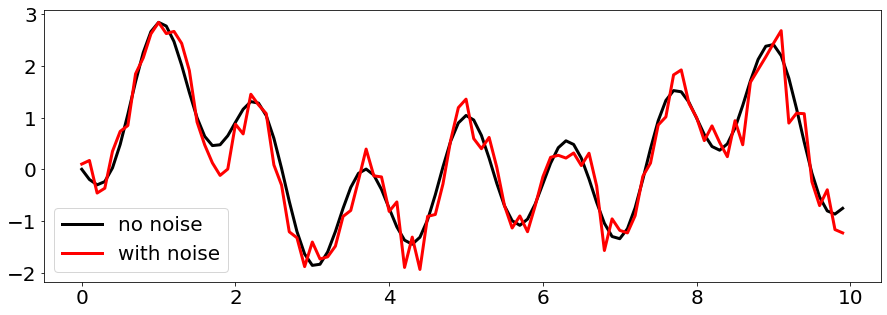

In [2]:
num_train_data = 4000
num_test_data = 1000
timestep = 0.1
tm = np.arange(0, (num_train_data+num_test_data)*timestep, timestep)
y = np.sin(tm) + np.sin(tm*np.pi/2) + np.sin(tm*(-3*np.pi/2))
SNR = 10
ypn = y + np.random.normal(0, 10**(-SNR/20), len(y))

plt.plot(tm[0:100], y[0:100], "k", lw=3, label="no noise")
plt.plot(tm[0:100], ypn[0:100], 'r', lw=3, label="with noise")
plt.legend()
plt.show()

# Prediction with Neural Networks (MLP)
<hr style = "border:2px solid black" ></hr>


- Let us start building our 3 layer Neural network now. The input layer takes 64 samples and produces 32 samples. 
- The hidden layer maps these 32 outputs from the first layer to 8 samples. 
- The final layer maps these 8 samples in to 1 predicted output. 
- Remember that the input size is provided with the `input_shape` parameter in the first layer.



In [3]:
def dnn_keras_tspred_model(train_data):
    model = keras.Sequential([
        keras.layers.Dense(32, activation=tf.nn.relu,
                           input_shape=(train_data.shape[1],)),
        keras.layers.Dense(8, activation=tf.nn.relu),
        keras.layers.Dense(1)
    ])
    optimizer = tf.keras.optimizers.Adam()
    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mae'])
    return model


- Now that we have the data, let us think about how to feed this data to the neural network for training. We know the network takes 64 samples at the input and produces one output sample. Since we want to train the network to predict the next sample, we want to use the 65th sample as the output label.

- The first input set is therefore from sample 0 to sample 63 (the first 64 samples) and the first label is sample 64 (the 65th sample). The second input set can either be a separate set of 64 samples (non-overlapping window), or we can choose to have a sliding window and take 64 samples from sample 1 to sample 64. Let us follow the sliding window approach, just to generate a lot of training data from the time series we have.



In [4]:
# prepare the train_data and train_labels
dnn_numinputs = 64
num_train_batch = 0
train_data = []
for k in range(num_train_data-dnn_numinputs-1):
    train_data = np.concatenate((train_data, ypn[k:k+dnn_numinputs]))
    num_train_batch = num_train_batch + 1
train_data = np.reshape(train_data, (num_train_batch, dnn_numinputs))
train_labels = y[dnn_numinputs:num_train_batch+dnn_numinputs]


- We said we are using sliding window with a shift of +1.
- Below is a print out of the first and second batches so you can easily see the shift.



In [5]:
train_data[0]

array([ 0.10044981,  0.17000807, -0.45979992, -0.36677886,  0.34735162,
        0.73215722,  0.84562643,  1.84533545,  2.15447046,  2.61830265,
        2.84090252,  2.62400314,  2.66647493,  2.43485727,  1.90916808,
        0.91393807,  0.47039297,  0.12284471, -0.1183568 ,  0.00410585,
        0.87196275,  0.68349803,  1.45122591,  1.24585054,  1.07760777,
        0.08368342, -0.30874031, -1.20957138, -1.32495698, -1.88256981,
       -1.40790737, -1.73578269, -1.69301547, -1.48723005, -0.91200515,
       -0.79679948, -0.21543683,  0.39076246, -0.12714727, -0.14800592,
       -0.81561089, -0.6316784 , -1.89895074, -1.31222271, -1.9374938 ,
       -0.91112017, -0.87446297, -0.28245521,  0.56018591,  1.19228223,
        1.35643481,  0.59309301,  0.39745076,  0.61631991,  0.03830862,
       -0.70294699, -1.13606394, -0.90302317, -1.20751088, -0.70536841,
       -0.1452379 ,  0.23085698,  0.27024485,  0.21682182])

In [6]:
train_data[1]

array([ 0.17000807, -0.45979992, -0.36677886,  0.34735162,  0.73215722,
        0.84562643,  1.84533545,  2.15447046,  2.61830265,  2.84090252,
        2.62400314,  2.66647493,  2.43485727,  1.90916808,  0.91393807,
        0.47039297,  0.12284471, -0.1183568 ,  0.00410585,  0.87196275,
        0.68349803,  1.45122591,  1.24585054,  1.07760777,  0.08368342,
       -0.30874031, -1.20957138, -1.32495698, -1.88256981, -1.40790737,
       -1.73578269, -1.69301547, -1.48723005, -0.91200515, -0.79679948,
       -0.21543683,  0.39076246, -0.12714727, -0.14800592, -0.81561089,
       -0.6316784 , -1.89895074, -1.31222271, -1.9374938 , -0.91112017,
       -0.87446297, -0.28245521,  0.56018591,  1.19228223,  1.35643481,
        0.59309301,  0.39745076,  0.61631991,  0.03830862, -0.70294699,
       -1.13606394, -0.90302317, -1.20751088, -0.70536841, -0.1452379 ,
        0.23085698,  0.27024485,  0.21682182,  0.31476286])

In [7]:
# Instantiate the model
model = dnn_keras_tspred_model(train_data)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 8)                 264       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 2,353
Trainable params: 2,353
Non-trainable params: 0
_________________________________________________________________


2022-03-05 07:47:51.775685: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.



- Let us look at the sizes of the time series data and the training data. See that we generated 5000 samples for our time series data, but we created 3935 x 64 = 251840 samples of input data to our neural network.

- The shape of train_data is the number of input sets x input length. Here, we have 3935 batches of input, each input being 64 samples long.



In [8]:
print(y.shape, train_data.shape, train_labels.shape)

(5000,) (3935, 64) (3935,)


In [9]:
EPOCHS = 100
strt_time = datetime.datetime.now()
history = model.fit(train_data, train_labels, epochs=EPOCHS,
                    validation_split=0.2, verbose=0,
                    callbacks=[])
curr_time = datetime.datetime.now()
timedelta = curr_time - strt_time
dnn_train_time = timedelta.total_seconds()
print("DNN training done. Time elapsed: ", timedelta.total_seconds(), "s")

DNN training done. Time elapsed:  8.447991 s


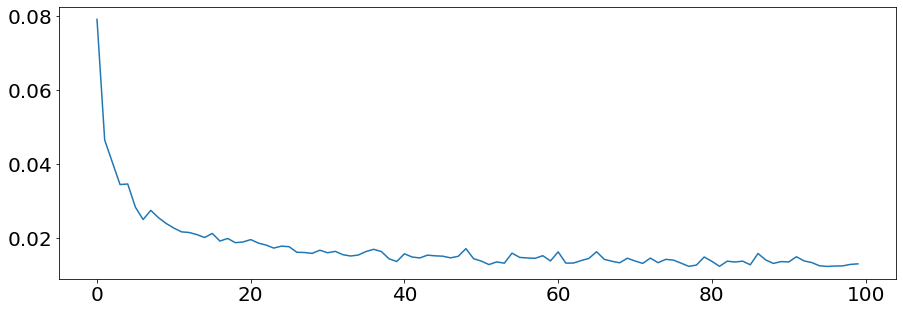

In [10]:
plt.plot(history.epoch, np.array(history.history['val_loss']),
         label='Val loss')
plt.show()


- Let us create the test data set exactly the same way as we created the training data sets, but use only that part of the time series that we have not used for training before. 

- We want to to test the NN with data it has not seen before to know if it has learnt from the training data.



In [11]:
# test how well DNN predicts now
num_test_batch = 0
strt_idx = num_train_batch
test_data = []
for k in range(strt_idx, strt_idx+num_test_data-dnn_numinputs-1):
    test_data = np.concatenate((test_data, ypn[k:k+dnn_numinputs]))
    num_test_batch = num_test_batch + 1
test_data = np.reshape(test_data, (num_test_batch, dnn_numinputs))
test_labels = y[strt_idx+dnn_numinputs:strt_idx+num_test_batch+dnn_numinputs]

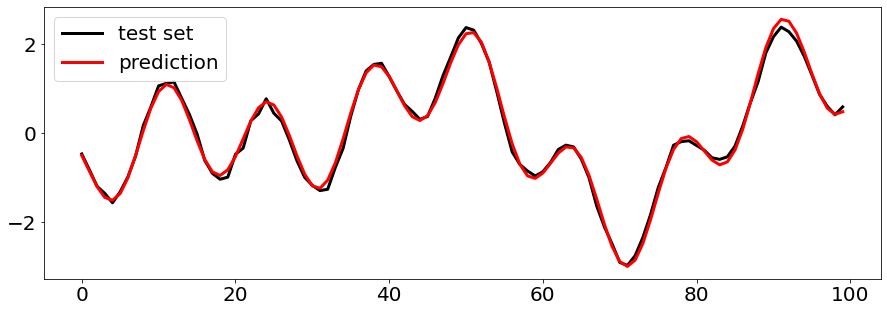

In [12]:
dnn_predictions = model.predict(test_data).flatten()
keras_dnn_err = test_labels - dnn_predictions
plt.plot(dnn_predictions[0:100], "k", lw=3, label="test set")
plt.plot(test_labels[0:100], 'r', lw =3, label="prediction")
plt.legend()
plt.show()

# Prediction with LMS algorithm
<hr style = "border:2px solid black" ></hr>

    
- We are going to compare the performance of a neural network against the traditional way by using a tap delay filter and adapting the weights based on the mean square error: this is the LMS (Least Mean Squares) filtering, an iterative approach to the optimal Weiner filter for estimating signal from noisy measurement. 

- We will use a L=64 tap filter to predict the next sample. We don’t need that large a filter, but let us keep the number of inputs per output sample same as what we used for neural network.

- The filter coefficients (or weights) are obtained by computing the error between predicted and measured sample, and adjusting the weights based on the correlation between mean square error and the input measurements.

- As you see in the code, `yrlms[k]` is the filter output when the inputs are `ypn[k-L:k]`, the error is computed as the difference between the noisy measured value `ypn[k]` and the filter output `yrlms[k]`. The correlation between measurement and error is given by the product of `ypn[k-L:k]` and e, and mu is the LMS step size (or learning rate).

- As we see, the LMS prediction is **equally good**, despite having much lower complexity.
    


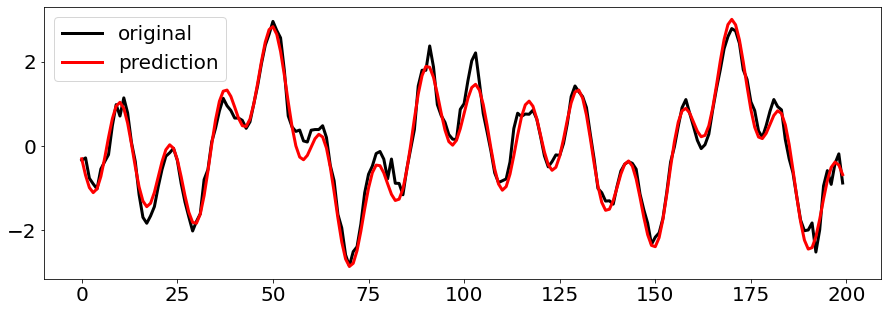

In [13]:
M = 1000
L = 64
yrlms = np.zeros(M+L)
wn = np.zeros(L)

mu = 0.005
for k in range(L, M+L):
    yrlms[k] = np.dot(ypn[k-L:k], wn)
    e = ypn[k] - yrlms[k]
    wn = wn+(mu*ypn[k-L:k]*e)

plt.plot(yrlms[600:800], "k", lw = 3, label ="original")
plt.plot(y[600:800], 'r', lw = 3,label="prediction")
plt.legend()
plt.show()

# Comparison: NN vs. LMS
<hr style = "border:2px solid black" ></hr>


- To be fair, I ignored the initial portion of the LMS to give it time to converge when measuring the mean square error and SNR. 
    
- Despite that, we see that the neural network performance is 5 dB better than the LMS performance!



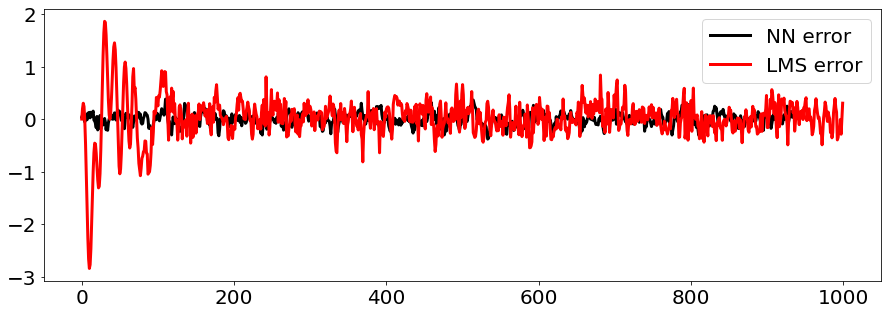

NN  prediction SNR: 20.370338836199295
LMS prediction SNR: 14.356971279990056


In [14]:
dnn_err = dnn_predictions - test_labels
lms_err = yrlms[0:M] - y[0:M]
plt.plot(dnn_err, "k", lw=3, label="NN error")
plt.plot(lms_err, 'r', lw=3, label="LMS error")
plt.legend()
plt.show()

dnn_mse = 10*np.log10(np.mean(pow(np.abs(dnn_err), 2)))
lms_mse = 10*np.log10(np.mean(pow(np.abs(lms_err[200:M]), 2)))
lms_sigpow = 10*np.log10(np.mean(pow(np.abs(y[0:M]), 2)))
dnn_sigpow = 10*np.log10(np.mean(pow(np.abs(test_labels), 2)))

print("NN  prediction SNR:", dnn_sigpow - dnn_mse)
print("LMS prediction SNR:", lms_sigpow - lms_mse)

# Fast Fourier Transform
<hr style = "border:2px solid black" ></hr>


- Alright, a neural network beat LMS by 5 dB in signal prediction, but let us see if a neural network **can be trained to do the Fourier Transform**.

- We will compare it to the FFT (Fast Fourier Transform) from SciPy FFTPack. 

- We will use the same signal we created before, the superposition of sine waves, to evaluate FFT as well. Let us look at the FFT ouput first.



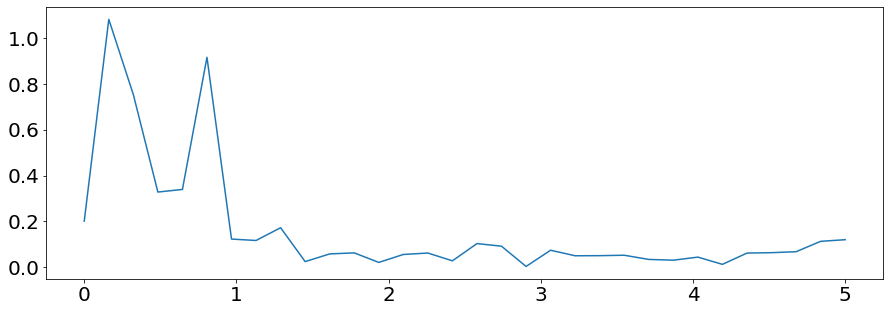

In [15]:
# 64 point FFT
N = 64

# Using the same noisy signal used for LMS
yf = scipy.fftpack.fft(ypn[0:N])

# Let us remove noise, easy to do at the FFT output
#yc = np.zeros(N,dtype=complex)
#cidx = np.where(np.abs(yf)>(N*0.2/2))[0]
# yc[cidx]=yf[cidx]

# 0 to Fs/2, Fs = 1/Ts
xf = np.linspace(0.0, 1.0/(2*timestep), int(N/2))

#fig, ax = plt.subplots()
# Plotting only from 0 to Fs/2
#plt.plot(xf, 2.0/N * np.abs(yc[:N//2]),'r')
plt.plot(xf, 2.0/N * np.abs(yf[:N//2]))
plt.show()


- Let us create a neural network model to **mimic** the FFT now. 

- In contrast to the model we created before where we have 64 inputs but only one output, this model needs to generate 64 outputs for every 64 sample input set.

- And since FFT inputs and outputs are complex, we need twice the number of samples at the input, arranged as real followed by imaginary. Since the outputs are also complex, we again 2 x NFFT samples.
    


In [16]:
def dnn_keras_fft_model(train_data, NFFT):
    model = keras.Sequential([
        keras.layers.Dense(NFFT*2, activation=tf.nn.relu,
                           input_shape=(train_data.shape[1],)),
        keras.layers.Dense(NFFT*2, activation=tf.nn.relu),
        keras.layers.Dense(NFFT*2)
    ])
    optimizer = tf.keras.optimizers.Adam()
    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mae'])
    return model

In [20]:
NFFT = 64
model = dnn_keras_fft_model(train_data, 64)

In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 128)               8320      
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                                 
 dense_5 (Dense)             (None, 128)               16512     
                                                                 
Total params: 41,344
Trainable params: 41,344
Non-trainable params: 0
_________________________________________________________________



- The rest of the code is fairly similar to the previous neural network training. Here, I am running 10,000 batches at a time, and I have an outer for loop to do multiple sets of 10,000 batches if the network needs more training. Note that this needs the model to be created outside the for loop, so that the weights are not reinitialized.

- See from model summary that there are almost 50,000 parameters for just a 64 point FFT. We can reduce this a bit since we are only evaluating real inputs while keeping the imaginary parts as zero, but the goal here is to quickly compare if the neural network can be trained to do the Fourier Transform.



DNN training done. Time elapsed:  24.996769 s


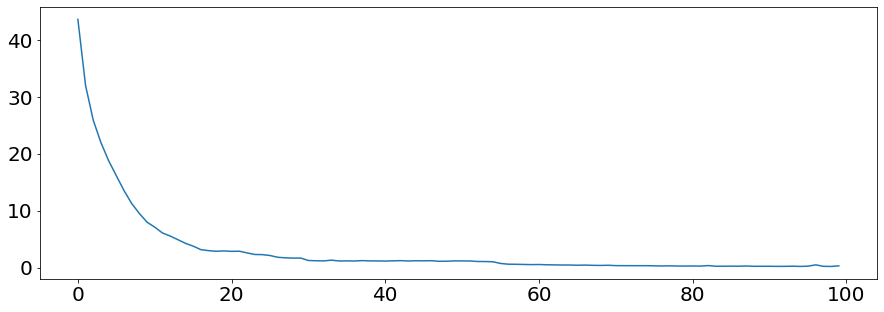

In [21]:
num_train_batch = 1
num_batches = 10000
train_data = np.random.normal(0, 1, (num_batches, NFFT*2))
train_labels = np.random.normal(0, 1, (num_batches, NFFT*2))

for k in range(num_train_batch):
    for el in range(num_batches):
        fftin = train_data[el, 0::2] + 1j*train_data[el, 1::2]
        train_labels[el, 0::2] = scipy.fftpack.fft(fftin).real
        train_labels[el, 1::2] = scipy.fftpack.fft(fftin).imag
    EPOCHS = 100
    strt_time = datetime.datetime.now()
    history = model.fit(train_data, train_labels, epochs=EPOCHS,
                        validation_split=0.2, verbose=0,
                        callbacks=[])
    curr_time = datetime.datetime.now()
    timedelta = curr_time - strt_time
    dnn_train_time = timedelta.total_seconds()
    print("DNN training done. Time elapsed: ", timedelta.total_seconds(), "s")
    plt.plot(history.epoch, np.array(history.history['val_loss']),
             label='Val loss')
    plt.show()
    train_data = np.random.normal(0, 1, (num_batches, NFFT*2))

# Comparison: NN vs. FFT
<hr style = "border:2px solid black" ></hr>


- Training is done. Let us now test the network using the same input samples we created for LMS. 
- We compare the neural network output to the FFT ouput and they are identical!



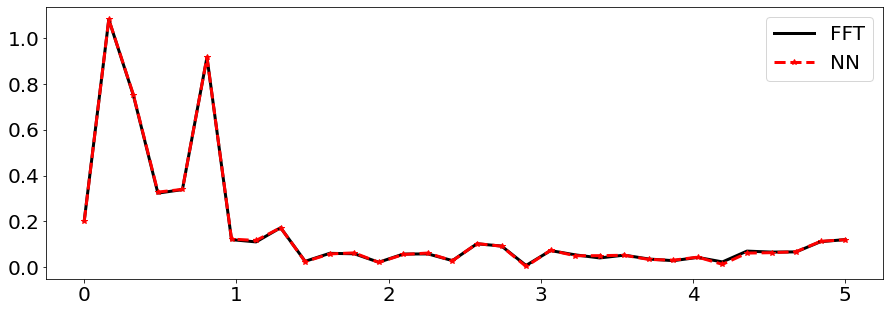

In [24]:
fftin = np.zeros((1, 2*NFFT))
fftin[:, 0::2] = ypn[0:NFFT]
fftout = model.predict(fftin).flatten()
fftout = fftout[0::2] + 1j*fftout[1::2]
plt.plot(xf, 2.0/NFFT * np.abs(fftout[0:NFFT//2]), "k", lw=3, label="FFT")
plt.plot(xf, 2.0/N * np.abs(yf[:N//2]), 'r*--', lw=3, label="NN")
plt.legend()
plt.show()


- Let us do one last evaluation before we conclude this article. We will compare the neural network output with the FFT output for some random input data, and see how the mean square error and SNR looks like.

- Running the code below, we get a decent 23.64 dB SNR. While we do see some samples every now and then where the error is high, for most part, the error is very small.



In [ ]:
test_data = np.random.normal(0, 1, (1000, NFFT*2))
test_labels = np.random.normal(0, 1, (1000, NFFT*2))
for el in range(1000):
    fftin = test_data[el, 0::2] + 1j*test_data[el, 1::2]
    test_labels[el, 0::2] = scipy.fftpack.fft(fftin).real
    test_labels[el, 1::2] = scipy.fftpack.fft(fftin).imag

dnn_out = model.predict(test_data).flatten()
keras_dnn_err = test_labels.flatten() - dnn_out
plt.plot(keras_dnn_err)
plt.show()

dnn_fft_mse = 10*np.log10(np.mean(pow(np.abs(keras_dnn_err), 2)))
labels_sigpow = 10*np.log10(np.mean(pow(np.abs(test_labels.flatten()), 2)))
print("Neural Network SNR compare to SciPy FFT: ", labels_sigpow - dnn_fft_mse)

# References
<hr style = "border:2px solid black" ></hr>


- https://towardsdatascience.com/machine-learning-and-signal-processing-103281d27c4b

